This notebook is meant to allow you to run a fast beginning to end training and validation toy experiment on a small model 

In [1]:
import os
print('os.getcwd()', os.getcwd())
import sys
sys.path.insert(1, '../')
print(sys.version)
import time

#plotting tools
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm as tqdm

#torch libs
import torch
print('torch.__version__', torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe_device = 0 if torch.cuda.is_available() else -1
print(pipe_device, device)

#huggingface transformers
import transformers
print('transformers.__version__',transformers.__version__)
from transformers import AutoTokenizer, pipeline

from datasets import load_dataset

#curious
from rlhf.models import GPT2HeadWithValueModel
from rlhf.rl import PPOTrainer
from rlhf.utils import LengthSampler, collater, respond_to_batch

#jupyter stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

os.getcwd() /home/carson/rlhf/notebooks
3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
torch.__version__ 1.11.0+cu113
0 cuda
transformers.__version__ 4.25.1


In [2]:
model_name = 'distilgpt2' #'gpt2' # 'gpt2-xl' # 'gpt2-large' #

gpt2_model = GPT2HeadWithValueModel.from_pretrained(
    model_name,
)

gpt2_model_reference = GPT2HeadWithValueModel.from_pretrained(
    model_name,
)

# put models onto GPU
gpt2_model.to(device);
gpt2_model_reference.to(device);

print("gpt2_model.device", gpt2_model.device)

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['v_head.summary.bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'v_head.summary.weight', 'transformer.h.3.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['v_head.summary.bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'v_head.summary.weight', 'transformer.h.3.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

cuda:0


This Warning is expected

```
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.10.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.3.attn.masked_bias', 'lm_head.weight', 'h.9.attn.masked_bias', 'h.6.attn.masked_bias', 'h.11.attn.masked_bias', 'h.5.attn.masked_bias', 'v_head.summary.weight', 'h.4.attn.masked_bias', 'h.1.attn.masked_bias', 'h.0.attn.masked_bias', 'h.2.attn.masked_bias', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

In [3]:
# load imdb with datasets
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
ds = ds.filter(lambda x: len(x["review"])>200, batched=False)

Found cached dataset imdb (/home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/25 [00:00<?, ?ba/s]

In [4]:
# load the reward model used to assign reward to model's outputs
sentiment_pipe = pipeline("sentiment-analysis","lvwerra/distilbert-imdb", device=pipe_device)

Downloading:   0%|          | 0.00/735 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
# reward model configs
sent_kwargs = {
    "return_all_scores": True,
    "function_to_apply": "none",
    "batch_size": 16
}

text = 'this movie was really bad!!'
sentiment_pipe(text, **sent_kwargs)

/home/carson/rlhf/venv/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'NEGATIVE', 'score': 2.3350484371185303},
  {'label': 'POSITIVE', 'score': -2.726576328277588}]]

In [6]:
# load the tokenizer

gpt2_tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
# modify the dataset with a new tokens column and query column
# these are used in the data feeder of the main train loop

input_size = LengthSampler(min_value = 4, max_value = 8)
output_size = LengthSampler(min_value = 4, max_value = 16)

def map_tokenize(sample):
    
    '''
    this function is applied to the dataset and 
    only the first few tokens of review are used for "tokens"
    they are decoded and stored as query in their text form
    '''
    
    sample["tokens"] = gpt2_tokenizer.encode(sample["review"])[:input_size()]
    sample["query"] = gpt2_tokenizer.decode(sample["tokens"])
    
    return sample

ds = ds.map(map_tokenize, batched=False)
dataloader = torch.utils.data.DataLoader(ds, batch_size=32, collate_fn=collater)

  0%|          | 0/24895 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


In [8]:
config = {
    "model_name": "lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "steps": 20000,
    "batch_size": 32, 
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    "txt_in_min_len": 4,
    "txt_in_max_len": 8,
    "txt_out_min_len": 4,
    "txt_out_max_len": 16,
    "lr": 1e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
}

In [ ]:
# instantiate the reinforcement learning trainer
reward_list = []

ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_reference, gpt2_tokenizer, **config)

total_ppo_epochs = 150
batch_size = 32

for epoch, batch in tqdm(zip(range(total_ppo_epochs), iter(dataloader)), total = total_ppo_epochs):
    
    ### initiate logging dicts
    logs, timing = dict(), dict()
    t0 = time.time()
    
    ### get start sequence input tokens
    query_tensors = [torch.tensor(t).long().to(device) for t in batch["tokens"]]
    
    ### Get responses from policy model
    t = time.time()
    response_tensors = []
    for i in range(batch_size):
        gen_len = output_size()
        query_tensor = query_tensors[i].unsqueeze(dim=0)
        response_tensor = respond_to_batch(gpt2_model, query_tensor, gen_len)
        response_tensors.append(response_tensor.squeeze())
        
    batch['response'] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]
    timing['time/get_response'] = time.time()-t
    
    #### Compute sentiment score (reward)
    t = time.time()
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = torch.tensor([output[1]["score"] for output in pipe_outputs]).to(device)
    timing['time/get_sentiment_preds'] = time.time()-t
    
    reward_list.append(torch.mean(rewards).item())
    
    #### Run PPO step 
    t = time.time()
    train_stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t


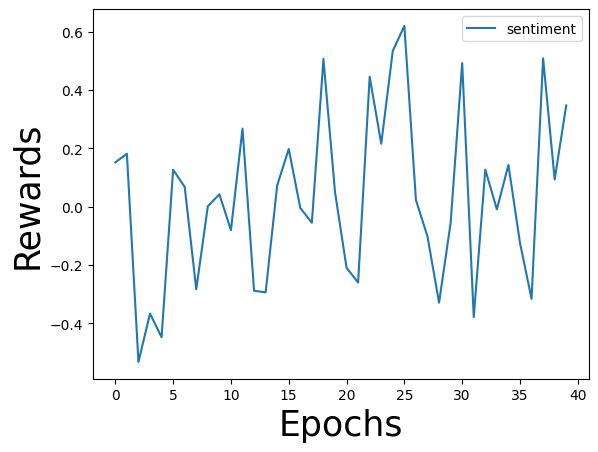

In [11]:
plt.figure()
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Rewards', fontsize=25)
plt.plot(reward_list, label='sentiment')
plt.legend()
plt.show()

expected reward vs epochs graph when you run until 150 epochs

<img src="https://raw.githubusercontent.com/clam004/rlhf/main/sample_files/rewards_epochs.png">

In [12]:
for i in range(len(batch["query"])):
    print(' ')
    print(batch["query"][i] + '  -->  ' + batch['response'][i])

 
Eric Rohmer's 'The  -->   Finally Over-Intense Camp' Ratio cod
 
If I only had one camera  -->  , and it is not one that I do not have,
 
Every so often a movie comes along  -->  , especially with early previews
 
I can hardly believe that this inert  -->   yet, even in two nights. This
 
As a fan of Eric  -->   Garner. He protests forces against lawlessness. Garner lets you live in the
 
As interesting as a sheet of  -->   data that I can share to build upon
 
I've seen most of  -->   those people I've connected enthusiastically and are someone I
 
I really tried to like this  -->   because I love developers and I know much more from everyone who wants to
 
Having seen Versus previously  -->  . I’ll think of the landmarking Ali’s Artist
 
I'll keep this short, as  -->   those…<|endoftext|>The Germans had been handing out numerous Sub
 
I don't know  -->   what he's employing a different name, and taking
 
Fashionably fragmented, yet infuri  -->  atingly interrelated, fonts destined 